# Seq2Seq Q&A Chatbot 구현

### 데이터 취득

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]

In [ ]:
!gdown 1lk7n_O-_4Rbj_OyAdOxcybB3c85GZ--T

Downloading...
From: https://drive.google.com/uc?id=1lk7n_O-_4Rbj_OyAdOxcybB3c85GZ--T
To: /content/ko.tsv
100% 85.4M/85.4M [00:01<00:00, 81.5MB/s]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


### 데이터 전처리

##### 토커나이저 학습 (sentencepiece 활용)

- 접두사, 점미사 처리 (bos, eos)
  - Train() 인자 cmd 옵션을 추가 (`<bos>, <eos>, <pad>, <oov>...`)
  - set_encode_extra_options(':')
  <br> set_encode_extra_options('bos:')
  <br> set_encode_extra_options(':eps')
  <br> set_encode_extra_options('bos:eos')
    

In [ ]:
import sentencepiece as spt
import tempfile

# 학습 데이터 준비
corpus = "\n".join(df['Q'].tolist() + df['A'].tolist())

# 임시 파일에 저장
with tempfile.NamedTemporaryFile(mode='w+', delete=False) as temp_file:
    temp_file.write(corpus)
    temp_file_path = temp_file.name


VOCAB_SIZE = 9000
model_prefix = 'chatbot'
cmd = f'--input={temp_file_path} --model_prefix={model_prefix} --vocab_size={VOCAB_SIZE} --bos_id=1 --eos_id=2'

spt.SentencePieceTrainer.Train(cmd)

In [ ]:
sp = spt.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# for doc in df['Q'].values[:3]:
#     print(doc)
#     print(sp.encode_as_pieces(doc))
#     print(sp.encode_as_ids(doc))
#     print()

True

### 학습용 데이터 Q_input, A_input, A_target 생성

In [ ]:
# BOS/EOS 옵션 설정
sp.set_encode_extra_options('bos:eos')

Q_inputs = [sp.encode_as_pieces(q)[1:-1] for q in df['Q']]
A_inputs = [sp.encode_as_pieces(a)[:-1] for a in df['A']]
A_targets = [sp.encode_as_pieces(a)[1:] for a in df['A']]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
Q_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
Q_tokenizer.fit_on_texts(Q_inputs)
Q_inputs_seq = Q_tokenizer.texts_to_sequences(Q_inputs)

Q_num_words = min(VOCAB_SIZE, len(Q_tokenizer.word_index))
Q_max_len = max([len(seq) for seq in Q_inputs_seq])

In [ ]:
A_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>', filters='')
A_tokenizer.fit_on_texts(A_inputs + A_targets)

A_inputs_seq = A_tokenizer.texts_to_sequences(A_inputs)
A_targets_seq = A_tokenizer.texts_to_sequences(A_targets)

A_num_words = min(VOCAB_SIZE, len(A_tokenizer.word_index))
A_max_len = max([len(seq) for seq in A_inputs_seq])

In [ ]:
# 패딩
from tensorflow.keras.preprocessing.sequence import pad_sequences

Q_inputs_padded = pad_sequences(Q_inputs_seq, maxlen=Q_max_len, padding='pre')
A_inputs_padded = pad_sequences(A_inputs_seq, maxlen=A_max_len, padding='post')
A_targets_padded = pad_sequences(A_targets_seq, maxlen=A_max_len, padding='post')

In [ ]:
# 한국어 임베딩
def make_kor2vec_tsv_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    import numpy as np

    embedding_matrix = np.zeros((num_words + 1, embedding_dim))
    pretrained_embedding = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split('\t')
            if len(values) != embedding_dim + 1:
                continue  # 잘못된 줄 건너뛰기
            word = values[0]
            vects = np.asarray(values[1:], dtype='float32')
            pretrained_embedding[word] = vects

    for word, index in tokenizer.word_index.items():
        if index > num_words:
            continue
        vects_ = pretrained_embedding.get(word)
        if vects_ is not None:
            embedding_matrix[index] = vects_

    return embedding_matrix

In [ ]:
EMBEDDING_DIM = 100

Q_embedding_matrix = make_kor2vec_tsv_embedding_matrix(
    Q_num_words,
    EMBEDDING_DIM,
    Q_tokenizer,
    './ko.tsv'
)

Q_embedding_matrix.shape

(7405, 100)

### 모델 생성 및 학습

##### 인코더 생성

In [ ]:
from tensorflow.keras import layers, models

LATENT_DIM = 512

encoder_inputs = layers.Input(shape=(Q_max_len,))
Q_embedding_layer = layers.Embedding(Q_num_words+1, EMBEDDING_DIM, weights=[Q_embedding_matrix])

x = Q_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 100)        │       740,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,924 (7.61 MB)

 Trainable params: 1,995,924 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더(teacher_forcing 모델) 생성

In [ ]:
decoder_inputs = layers.Input(shape=(A_max_len,))
A_embedding_layer = layers.Embedding(A_num_words+1, EMBEDDING_DIM)

x = A_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(A_num_words+1, activation='softmax')
decoder_outputs = decoder_dense(x)

chatboot_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

chatboot_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 100)   │    740,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 36, 100)   │    561,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 36, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 36, 5615)  │  2,880,495 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,693,343 (25.53 MB)

 Trainable params: 6,693,343 (25.53 MB)

 Non-trainable params: 0 (0.00 B)

##### 학습

In [ ]:
  chatboot_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = chatboot_model.fit(
    [Q_inputs_padded, A_inputs_padded],
    A_targets_padded,
    batch_size=64,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.7749 - loss: 2.4562 - val_accuracy: 0.8124 - val_loss: 1.4255
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8444 - loss: 1.1124 - val_accuracy: 0.8147 - val_loss: 1.3548
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8458 - loss: 1.0465 - val_accuracy: 0.8166 - val_loss: 1.3342
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8487 - loss: 1.0011 - val_accuracy: 0.8205 - val_loss: 1.3189
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8520 - loss: 0.9728 - val_accuracy: 0.8222 - val_loss: 1.3119
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8560 - loss: 0.9301 - val_accuracy: 0.8240 - val_loss: 1.3045
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8587 - loss: 0.8992 - val_accuracy: 0.8260 - val_loss: 1.2976
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8600 - loss: 0

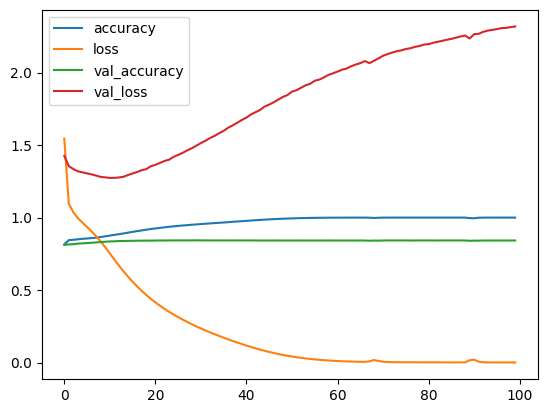

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

### 모델 추론

In [ ]:
# 모델 저장
chatboot_model.save('chatboot_model.keras')

In [ ]:
# 모델 로드
from tensorflow.keras.models import load_model
chatboot_model = load_model('chatboot_model.keras')

##### 디코더 (추론 모델) 생성

In [ ]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = A_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs =[decoder_outputs_] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    561,500 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[1][0… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 5615)   │  2,880,495 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,697,419 (17.92 MB)

 Trainable params: 4,697,419 (17.92 MB)

 Non-trainable params: 0 (0.00 B)

##### 추론 함수

In [51]:
def translate(input_seq):
  encoder_states_value = encoder_model.predict(input_seq)
  decoder_states_value = encoder_states_value

  bos_index = A_tokenizer.word_index['<s>']
  eos_index = A_tokenizer.word_index['</s>']

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = bos_index

  output_sentence = []

  for _ in range(A_max_len):
    output_tokens, h, c = decoder_inference_model.predict([target_seq] + [decoder_states_value[0], decoder_states_value[1]])

    pred_proba = output_tokens[0, 0, :]
    pred_index = np.argmax(pred_proba)

    if pred_index == eos_index:
      break

    if pred_index > 0:
      word = A_tokenizer.index_word[pred_index]
      output_sentence.append(word)

    target_seq[0, 0] = pred_index
    decoder_states_value = [h, c]

  return output_sentence

##### 테스트

In [43]:
import numpy as np

for _ in range(5):
  idx = np.random.choice(len(Q_inputs_padded))
  input_seq = Q_inputs_padded[idx:idx+1]
  output_sent = translate(input_seq)
  print('입력한 문장:', sp.decode_pieces(Q_inputs[idx]))
  print('학습한 대답:', sp.decode_pieces(A_inputs[idx]))
  print('추론한 대답:', sp.decode_pieces(output_sent))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
입력한 문장:  스터디 카페 좋다
학습한 대답:  공부하러 왔나봐요.
추론한 대답:  공부하러 왔나봐요.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
입력한 문장:  남자친구가 질투하는 거 귀여워
학습한 대답:  은근 기분이 좋죠.
추론한 대답:  은근 기분이 좋죠.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
입

### 간단한 Chatbot 구현

1. 사용자의 입력을 받아 (처리)
2. 추론 함수에 전달해서
3. 응답을 출력
4. 1~3 '종료' 전까지 반복

In [59]:
def translate_QNA(Q_text):
  input_seq = Q_tokenizer.texts_to_sequences(Q_text)
  input_seq = pad_sequences(input_seq, maxlen=Q_max_len)
  return translate(input_seq)

while True:
    user_input = input("Q:")
    if user_input == '종료':
        break
    response = translate_QNA([user_input])
    print("A:", response)

Q:배고파
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
A: 제가 있잖아요.
Q:종료
